In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10



from datetime import datetime, timedelta,date
from __future__ import division

import plotly.offline as pyoff
import plotly.graph_objs as go

import warnings
warnings.filterwarnings("ignore")

#import Keras
import keras
from keras.layers import LSTM,Dropout,Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM

from sklearn.model_selection import KFold, cross_val_score, train_test_split #split data in testing and training portion
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing #standardize data
from sklearn.linear_model import LinearRegression



In [109]:
df = pd.read_excel('TTC_historical_ridership_data.xlsx')
df

,Unnamed: 0,FARE MEDIA,2019,2018,2017,2016,2015 *,2014,2013,2012,...,1994,1993,1992,1991,1990,1989,1988,1987,1986,1985
0,WHO,ADULT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,PRESTO - 1 RIDE & 2 RIDE TICKET,1906.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,PRESTO - DAY PASS,829.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,PRESTO - ADULT SINGLE RIDE,166871.0,110950.0,67829.0,27397.0,13323.0,9862.0,8194.0,4399.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,PRESTO - ADULT TFE SINGLE RIDE,4340.0,1496.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,NaN,SUB-TOTAL,290079.0,256866.0,272103.0,285180.0,295062.0,289523.0,285226.0,279425.0,...,197232.0,204425.0,211756.0,235017.0,256553.0,252648.0,255418.0,253484.0,252100.0,239470.0
58,NaN,SYSTEM TOTAL,525470.0,521404.0,533216.0,538079.0,534005.0,534815.0,525194.0,514007.0,...,388252.0,393485.0,404251.0,424167.0,459234.0,450726.0,463475.0,456884.0,441012.0,432160.0
59,WHEN,WEEKDAY,426300.0,417245.0,424155.0,424117.0,423808.0,423269.0,416297.0,406913.0,...,319087.0,324529.0,334515.0,350714.0,379987.0,374024.0,385093.0,382917.0,369295.0,358947.0
60,NaN,WEEKEND/HOLIDAY,99170.0,104159.0,109061.0,113962.0,110197.0,111546.0,108897.0,107094.0,...,69165.0,68956.0,69736.0,73453.0,79247.0,76702.0,78382.0,73967.0,71717.0,73213.0


In [110]:
# system_total_data_frame = df.loc[61]
# # system_total_data_frame = pd.DataFrame(system_total_data_frame)
# # system_total_data_frame['Index'] = range(1,len(system_total_data_frame) + 1)
# system_total_data_frame

df_list = df.values.tolist()
df_list = df_list[-1]
df_list = df_list[2:]
df_list = df_list[::-1]

columns = ['N_PPL']
df_list = pd.DataFrame(list(df_list), columns=columns)

# df_list['Year'] = [i for i in range(1985,2020)][::-1]
df_list['Year'] = pd.date_range(start='1985', periods=len(df_list), freq='Y').year

df = df_list

df



,N_PPL,Year
0,432160.0,1985
1,441012.0,1986
2,456884.0,1987
3,463475.0,1988
4,450726.0,1989
5,459234.0,1990
6,424167.0,1991
7,404251.0,1992
8,393485.0,1993
9,388252.0,1994


Text(0, 0.5, 'Number of People ( /1000)')

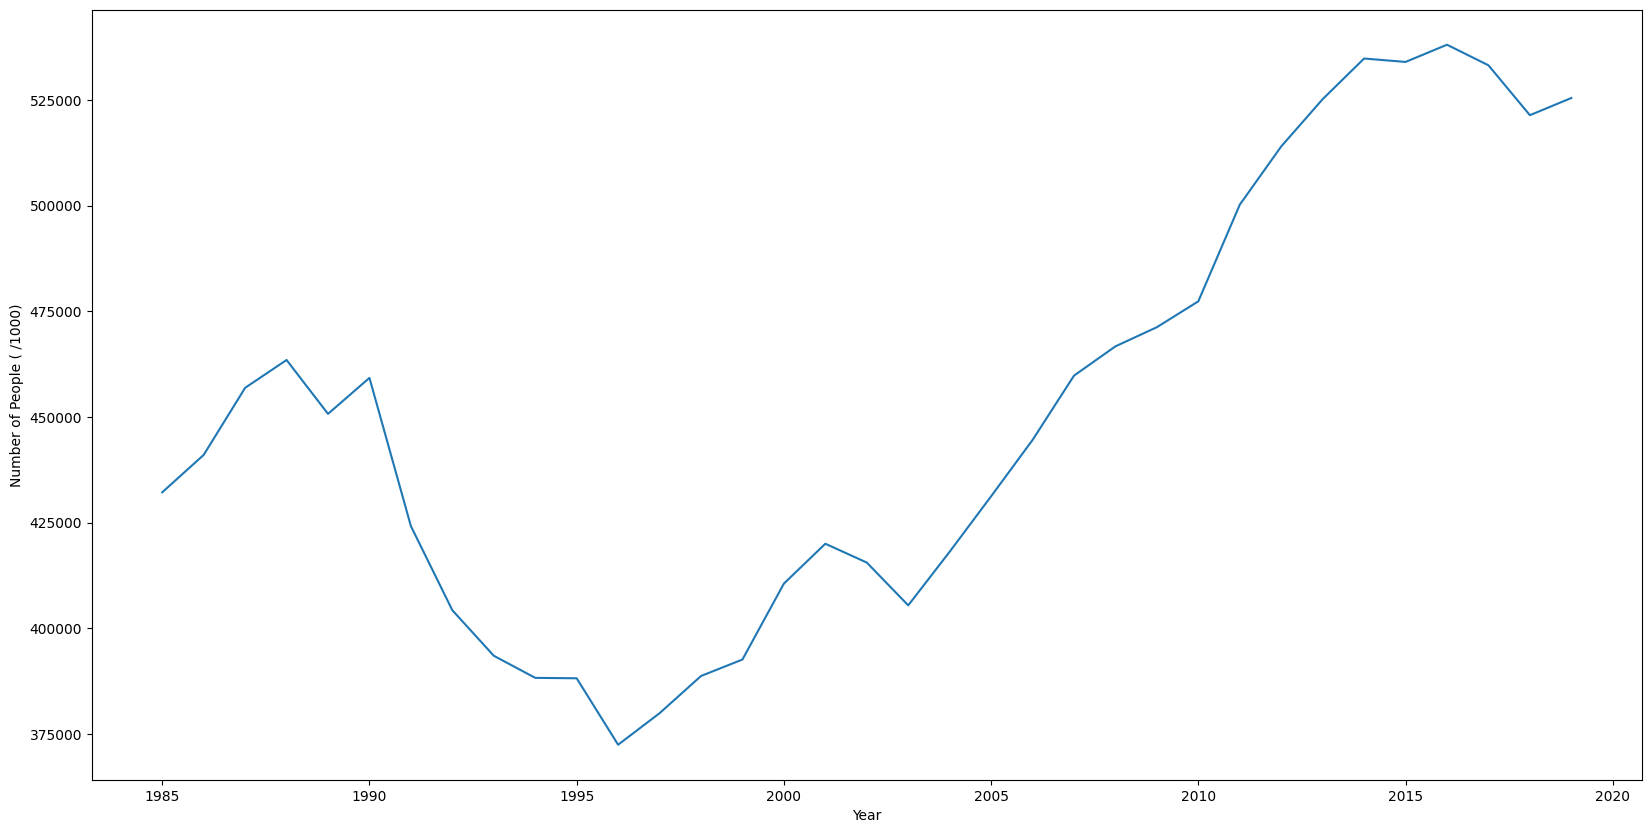

In [111]:
plt.plot(df['Year'].values.tolist(),df['N_PPL'].values.tolist())
plt.xlabel('Year')
plt.ylabel('Number of People ( /1000)')

In [120]:
forecast = 3
df['Prediction'] = df["N_PPL"].shift(-3)

#X datas4et feautures
#Y datatset is labels

X = np.array(df.drop(['Prediction'],1))
X = preprocessing.scale(X)

X_forecast = X[-forecast:]
X = X[:-forecast]

y = np.array(df['Prediction'])
y = y[:-forecast]



In [124]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
clf = LinearRegression() #stands for estimator instance classifier
clf.fit(X_train,y_train)

confidence = clf.score(X_test,y_test)
confidence

0.9134259038487379

In [125]:
forecast_predicted = clf.predict(X_forecast)
forecast_predicted

array([544507.01223837, 538691.09392551, 543424.92293088])

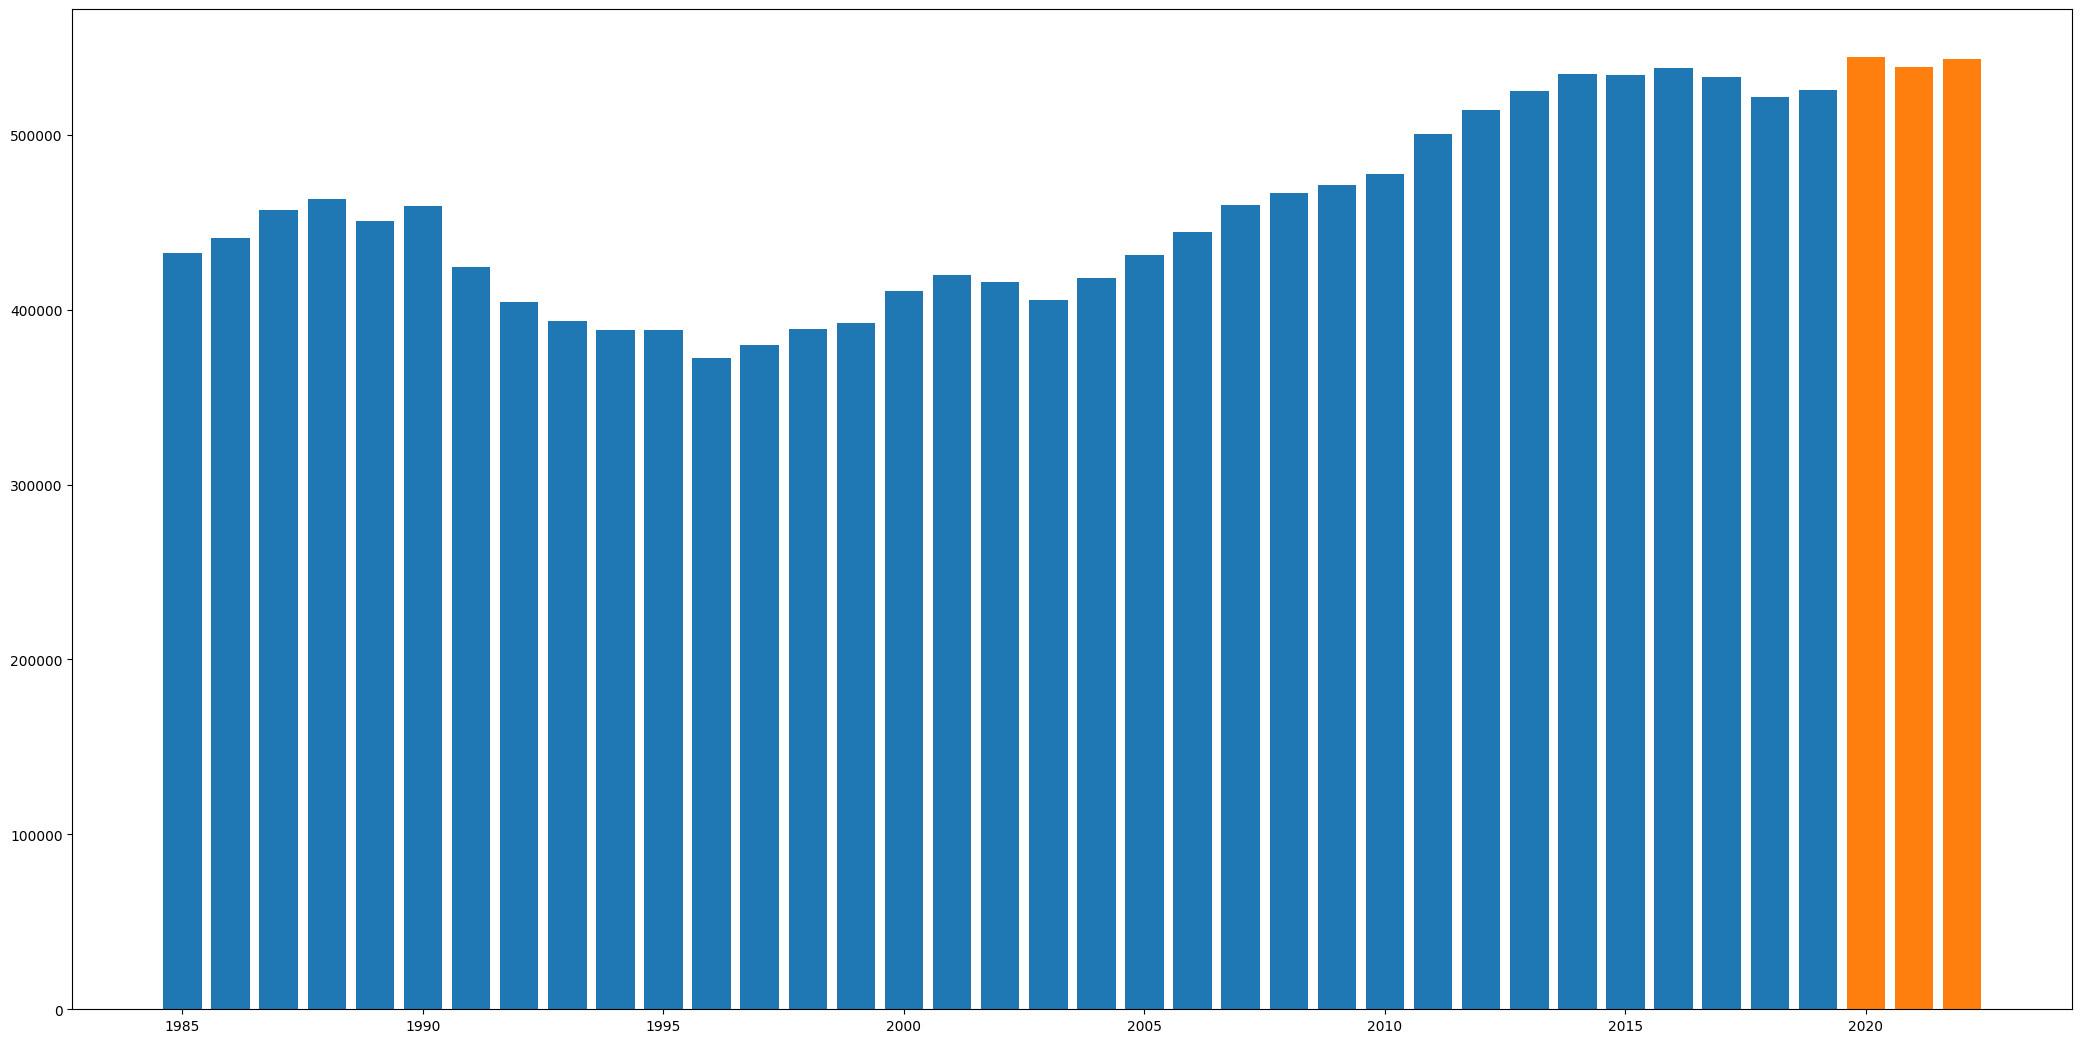

In [165]:
# dates = pd.date_range(start='2020', periods=3, freq='Y').year
# dates = list(dates)
# plt.plot([34,35,36],list(forecast_predicted),color = 'r')
# df["N_PPL"].plot(color='g')
# plt.xlim([0, 40])

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = df['Year']
number_of_ppl = df["N_PPL"]
ax.bar(langs,number_of_ppl)

pred_year = [2020,2021,2022]
pred_number_of_ppl = forecast_predicted
ax.bar(pred_year,pred_number_of_ppl)
plt.show()